In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from neuralprophet import NeuralProphet, set_log_level

from scipy import stats

%matplotlib inline

/Users/tott/opt/anaconda3/envs/py310/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import datetime

In [3]:
now = datetime.datetime.now()

In [4]:
print(now)

2024-10-17 14:10:00.968239


In [5]:
# Enter the begin and end dates for the gage and flow data

begin_date = '2023-01-01T00:00:00.000-05:00'
end_date = '2024-08-28T00:00:00.000-05:00'

#01473730 - Schuylkill River at Conshohocken, PA

In [6]:
#Read in raw stream gage data
gage = pd.read_csv('https://nwis.waterservices.usgs.gov/nwis/iv/?sites=01473730&parameterCd=00065&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=26)
gage = gage.iloc[1: , :]


In [7]:
gage['328674_00065'] = gage['328674_00065'].astype(float)
gage = gage[['datetime','328674_00065']]
gage = gage.set_index('datetime')
gage.head()

,328674_00065
datetime,
2023-05-16 12:45,7.18
2023-05-16 13:15,7.18
2023-05-16 13:30,7.19
2023-05-16 13:45,7.19
2023-05-16 14:00,7.16


In [8]:
#Read in raw flow data
flow = pd.read_csv('https://waterservices.usgs.gov/nwis/iv/?sites=01473730&parameterCd=00060&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=26)
flow = flow.iloc[1: , :]

In [9]:
flow['328771_00060'] = flow['328771_00060'].astype(float)
flow = flow[['datetime','328771_00060']]
flow = flow.set_index('datetime')
flow.head()

,328771_00060
datetime,
2023-05-16 12:45,1400.0
2023-05-16 13:15,1400.0
2023-05-16 13:30,1410.0
2023-05-16 13:45,1410.0
2023-05-16 14:00,1370.0


In [10]:
# Merge datasets together on datetime index and check if everything is good
df=pd.merge(gage, flow, how='inner', left_index=True, right_index=True)
df.head()

,328674_00065,328771_00060
datetime,,
2023-05-16 12:45,7.18,1400.0
2023-05-16 13:15,7.18,1400.0
2023-05-16 13:30,7.19,1410.0
2023-05-16 13:45,7.19,1410.0
2023-05-16 14:00,7.16,1370.0


In [11]:
# Rename gage and flow rate colums to something humane and check the dataframe
df = df.rename(columns={"328674_00065": "Gage", "328771_00060": "Flow"  })
df.head()

,Gage,Flow
datetime,,
2023-05-16 12:45,7.18,1400.0
2023-05-16 13:15,7.18,1400.0
2023-05-16 13:30,7.19,1410.0
2023-05-16 13:45,7.19,1410.0
2023-05-16 14:00,7.16,1370.0


In [12]:
#check the number of training rows
print('number of rows = ', df.shape[0])

number of rows =  45919


In [13]:
# Shift Gage readings by X time units and set as training label, calculate gage and flow rates of change 
def gage_forecast(df, forecast):
    df['Gage_forecast_'+str(forecast)] = df['Gage'].shift(-forecast)
    df['Gage_forecast_'+str(forecast_horizon)] = df['Gage_forecast_'+str(forecast_horizon)]
    df['Gage_diff'] = df['Gage'].shift(-1) - df['Gage']
    df['Flow_diff'] = df['Flow'].shift(-1) - df['Flow']
    df.drop(df.tail(forecast).index,inplace=True) # drop last n rows
    return df

In [14]:
# Set the forecast horizon. Note this is in time units, each time unit is 15 minutes. 
forecast_horizon = 12

In [15]:
# Process gage forecast and check results
df = gage_forecast(df, forecast_horizon)
df.tail(200)

,Gage,Flow,Gage_forecast_12,Gage_diff,Flow_diff
datetime,,,,,
2024-08-25 21:15,6.75,804.0,6.78,0.01,13.0
2024-08-25 21:30,6.76,817.0,6.78,0.00,0.0
2024-08-25 21:45,6.76,817.0,6.77,-0.01,-13.0
2024-08-25 22:00,6.75,804.0,6.78,0.00,0.0
2024-08-25 22:15,6.75,804.0,6.77,0.00,0.0
...,...,...,...,...,...
2024-08-27 21:00,6.73,779.0,6.73,0.00,0.0
2024-08-27 21:15,6.73,779.0,6.73,0.00,0.0
2024-08-27 21:30,6.73,779.0,6.72,0.00,0.0


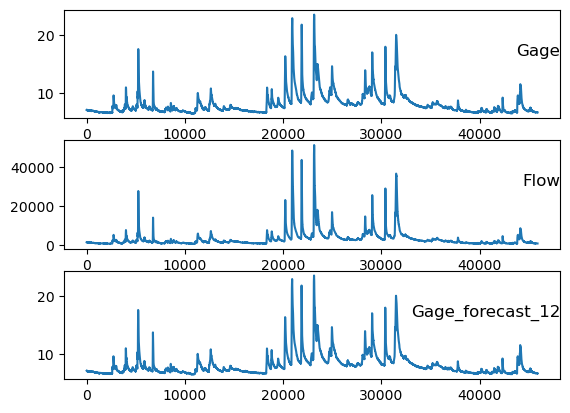

In [16]:
# Make a quick visual of stacked charts - this is a reality check
values = df.values
groups = [0,1,2,]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

Text(0, 0.5, 'Gage (ft)')

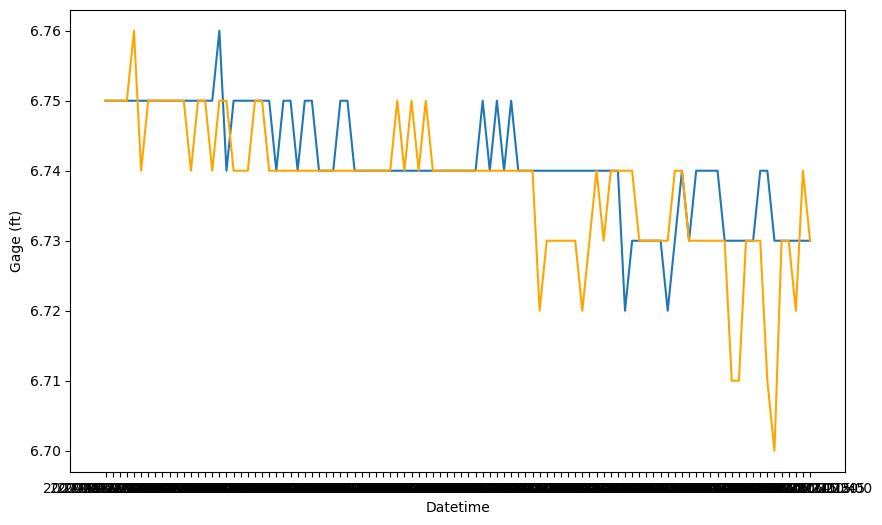

In [17]:
# Check if gage forecast is shifted from gage reading
plt.figure(figsize=(10,6))
plt.plot(df['Gage'].tail(100))
plt.plot(df['Gage_forecast_'+str(forecast_horizon)].tail(100), color = 'orange')
plt.xlabel('Datetime')
plt.ylabel('Gage (ft)')

In [18]:
df = df.reset_index()

In [19]:
df

,datetime,Gage,Flow,Gage_forecast_12,Gage_diff,Flow_diff
0,2023-05-16 12:45,7.18,1400.0,7.17,0.00,0.0
1,2023-05-16 13:15,7.18,1400.0,7.14,0.01,10.0
2,2023-05-16 13:30,7.19,1410.0,7.17,0.00,0.0
3,2023-05-16 13:45,7.19,1410.0,7.15,-0.03,-40.0
4,2023-05-16 14:00,7.16,1370.0,7.17,0.00,0.0
...,...,...,...,...,...,...
45902,2024-08-27 21:00,6.73,779.0,6.73,0.00,0.0
45903,2024-08-27 21:15,6.73,779.0,6.73,0.00,0.0
45904,2024-08-27 21:30,6.73,779.0,6.72,0.00,0.0
45905,2024-08-27 21:45,6.73,779.0,6.74,0.00,0.0


In [20]:
duplicate = df[df.duplicated()]
 
print("Duplicate Rows :")

Duplicate Rows :


In [21]:
duplicate

,datetime,Gage,Flow,Gage_forecast_12,Gage_diff,Flow_diff
16625,2023-11-05 01:00,6.91,1010.0,6.91,0.0,0.0
16627,2023-11-05 01:00,6.91,1010.0,6.90,0.0,0.0
16630,2023-11-05 01:15,6.91,1010.0,6.90,0.0,0.0
16631,2023-11-05 01:15,6.91,1010.0,6.90,0.0,0.0
16633,2023-11-05 01:30,6.91,1010.0,6.90,0.0,0.0
16634,2023-11-05 01:30,6.91,1010.0,6.90,0.0,0.0
16635,2023-11-05 01:30,6.91,1010.0,6.90,0.0,0.0


In [22]:
df.drop_duplicates(subset=duplicate, inplace=True) #, 

In [23]:
df

,datetime,Gage,Flow,Gage_forecast_12,Gage_diff,Flow_diff
0,2023-05-16 12:45,7.18,1400.0,7.17,0.00,0.0
1,2023-05-16 13:15,7.18,1400.0,7.14,0.01,10.0
2,2023-05-16 13:30,7.19,1410.0,7.17,0.00,0.0
3,2023-05-16 13:45,7.19,1410.0,7.15,-0.03,-40.0
4,2023-05-16 14:00,7.16,1370.0,7.17,0.00,0.0
...,...,...,...,...,...,...
45902,2024-08-27 21:00,6.73,779.0,6.73,0.00,0.0
45903,2024-08-27 21:15,6.73,779.0,6.73,0.00,0.0
45904,2024-08-27 21:30,6.73,779.0,6.72,0.00,0.0
45905,2024-08-27 21:45,6.73,779.0,6.74,0.00,0.0


In [24]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [25]:
df = df.set_index('datetime')

In [27]:
df = df.resample('60Min').agg({'Gage': 'last', 'Flow': 'last',
                                      'Gage_forecast_12': 'last', 'Gage_diff':'last',
                                      'Flow_diff':'last'})#

In [28]:
#df['Gage_diff'] = df['Pompton_gage'].shift(-1) - df['Pompton_gage']
#df['Warning'] = np.where(df['Pompton_gauge']>16, 1, 0)

In [29]:
df

,Gage,Flow,Gage_forecast_12,Gage_diff,Flow_diff
datetime,,,,,
2023-05-16 12:00:00,7.18,1400.0,7.17,0.00,0.0
2023-05-16 13:00:00,7.19,1410.0,7.15,-0.03,-40.0
2023-05-16 14:00:00,7.17,1380.0,7.16,0.00,0.0
2023-05-16 15:00:00,7.16,1370.0,7.14,0.01,10.0
2023-05-16 16:00:00,7.15,1360.0,7.16,0.02,20.0
...,...,...,...,...,...
2024-08-27 18:00:00,6.74,791.0,6.73,-0.01,-12.0
2024-08-27 19:00:00,6.73,779.0,6.73,0.00,0.0
2024-08-27 20:00:00,6.73,779.0,6.70,0.00,0.0


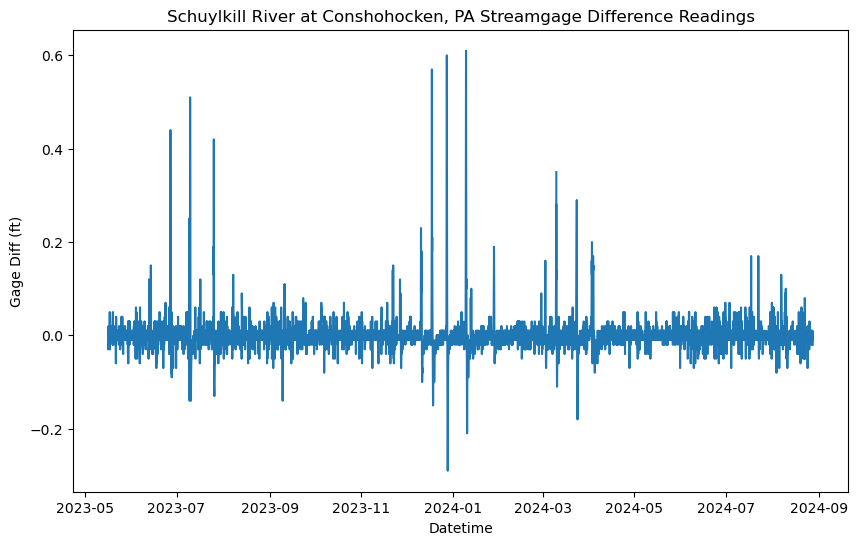

In [32]:
plt.figure(figsize=(10,6))
plt.plot(df['Gage_diff'])
plt.xlabel('Datetime')
plt.ylabel('Gage Diff (ft)')
 
# displaying the title
plt.title("Schuylkill River at Conshohocken, PA Streamgage Difference Readings")
plt.show()

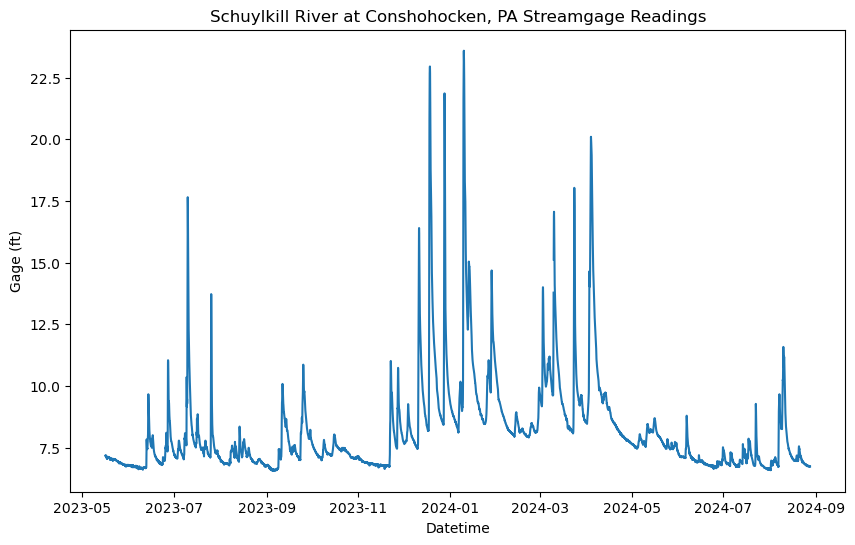

In [33]:
plt.figure(figsize=(10,6))
plt.plot(df['Gage'])
plt.xlabel('Datetime')
plt.ylabel('Gage (ft)')
 
# displaying the title
plt.title("Schuylkill River at Conshohocken, PA Streamgage Readings")
plt.show()
plt.show()

In [34]:
df.head()

,Gage,Flow,Gage_forecast_12,Gage_diff,Flow_diff
datetime,,,,,
2023-05-16 12:00:00,7.18,1400.0,7.17,0.00,0.0
2023-05-16 13:00:00,7.19,1410.0,7.15,-0.03,-40.0
2023-05-16 14:00:00,7.17,1380.0,7.16,0.00,0.0
2023-05-16 15:00:00,7.16,1370.0,7.14,0.01,10.0
2023-05-16 16:00:00,7.15,1360.0,7.16,0.02,20.0


In [35]:
print('number of rows = ', df.shape[0])

number of rows =  11267


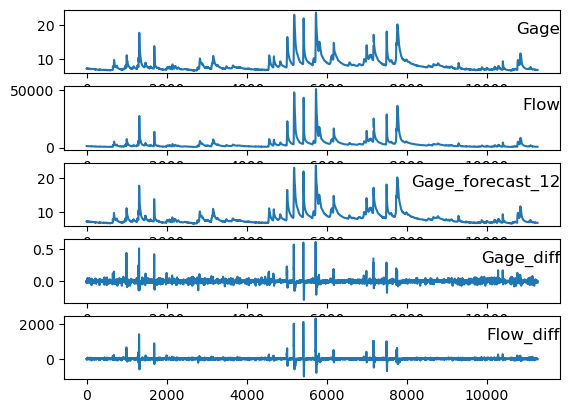

In [36]:
values = df.values
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [37]:
df.head()

,Gage,Flow,Gage_forecast_12,Gage_diff,Flow_diff
datetime,,,,,
2023-05-16 12:00:00,7.18,1400.0,7.17,0.00,0.0
2023-05-16 13:00:00,7.19,1410.0,7.15,-0.03,-40.0
2023-05-16 14:00:00,7.17,1380.0,7.16,0.00,0.0
2023-05-16 15:00:00,7.16,1370.0,7.14,0.01,10.0
2023-05-16 16:00:00,7.15,1360.0,7.16,0.02,20.0


In [38]:
df.tail()

,Gage,Flow,Gage_forecast_12,Gage_diff,Flow_diff
datetime,,,,,
2024-08-27 18:00:00,6.74,791.0,6.73,-0.01,-12.0
2024-08-27 19:00:00,6.73,779.0,6.73,0.00,0.0
2024-08-27 20:00:00,6.73,779.0,6.70,0.00,0.0
2024-08-27 21:00:00,6.73,779.0,6.74,0.00,0.0
2024-08-27 22:00:00,6.73,779.0,6.73,-0.02,-25.0


In [39]:
df = df.reset_index()

In [41]:
#df['datetime'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)

In [40]:
df = df.rename(columns={"datetime": "ds", "Gage": "y"})

In [41]:
#df = df[['ds','y']]

In [42]:
df.dtypes

ds                  datetime64[ns]
y                          float64
Flow                       float64
Gage_forecast_12           float64
Gage_diff                  float64
Flow_diff                  float64
dtype: object

In [43]:
df

,ds,y,Flow,Gage_forecast_12,Gage_diff,Flow_diff
0,2023-05-16 12:00:00,7.18,1400.0,7.17,0.00,0.0
1,2023-05-16 13:00:00,7.19,1410.0,7.15,-0.03,-40.0
2,2023-05-16 14:00:00,7.17,1380.0,7.16,0.00,0.0
3,2023-05-16 15:00:00,7.16,1370.0,7.14,0.01,10.0
4,2023-05-16 16:00:00,7.15,1360.0,7.16,0.02,20.0
...,...,...,...,...,...,...
11262,2024-08-27 18:00:00,6.74,791.0,6.73,-0.01,-12.0
11263,2024-08-27 19:00:00,6.73,779.0,6.73,0.00,0.0
11264,2024-08-27 20:00:00,6.73,779.0,6.70,0.00,0.0
11265,2024-08-27 21:00:00,6.73,779.0,6.74,0.00,0.0


In [44]:
print('number of rows = ', df.shape[0])

number of rows =  11267


In [45]:
df.drop_duplicates(subset='ds', inplace=True) 

In [46]:
print('number of rows = ', df.shape[0])

number of rows =  11267


In [47]:
freq = 'auto' #D W-FRI, MS
n_forecasts = 6

In [58]:
m = NeuralProphet(
    growth="off",
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    n_lags=10,
    #num_hidden_layers=40,
    #d_hidden=144,
    learning_rate=0.003,
    n_forecasts = n_forecasts,
    n_changepoints = 100,
    changepoints_range=0.95,
    batch_size=32,
    epochs=200,
    drop_missing = True,
)

df_train, df_test = m.split_df(df, freq=freq, valid_p=0.8)
m.add_lagged_regressor("Flow")
m.add_lagged_regressor("Gage_forecast_12")
m.add_lagged_regressor("Gage_diff")
m.add_lagged_regressor("Flow_diff")
metrics = m.fit(df_train, freq=freq, validation_df=df_test) #, progress="plot-all"

WARNING - (py.warnings._showwarnmsg) - /Users/tott/opt/anaconda3/envs/py310/lib/python3.10/site-packages/neuralprophet/df_utils.py:1127: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.991% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as h
WARNING - (NP.forecaster.__handle_missing_data) - 1 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 1 NaN values in column y were auto-imputed.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of l

In [59]:
metrics.tail(n_forecasts)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
194,0.002147,0.058297,0.138751,0.001747,0.0,0.002747,0.062383,0.153746
195,0.002146,0.058557,0.139967,0.001746,0.0,0.002730,0.062223,0.153399
196,0.002144,0.058453,0.135569,0.001745,0.0,0.002734,0.062210,0.153455
197,0.002144,0.058468,0.134003,0.001745,0.0,0.002728,0.062175,0.153335
198,0.002144,0.058503,0.136076,0.001744,0.0,0.002727,0.062180,0.153328
199,0.002144,0.058503,0.136265,0.001744,0.0,0.002727,0.062179,0.153328


WARNING - (py.warnings._showwarnmsg) - /Users/tott/opt/anaconda3/envs/py310/lib/python3.10/site-packages/neuralprophet/df_utils.py:1127: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.989% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/tott/opt/anaconda3/envs/py310/lib/python3.10/site-packages/neuralprophet/df_utils.py:1127: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/tott/opt/anaconda3/envs/py310/lib/python3.10/site-packages/neuralprophet/df_utils.py:1127: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as

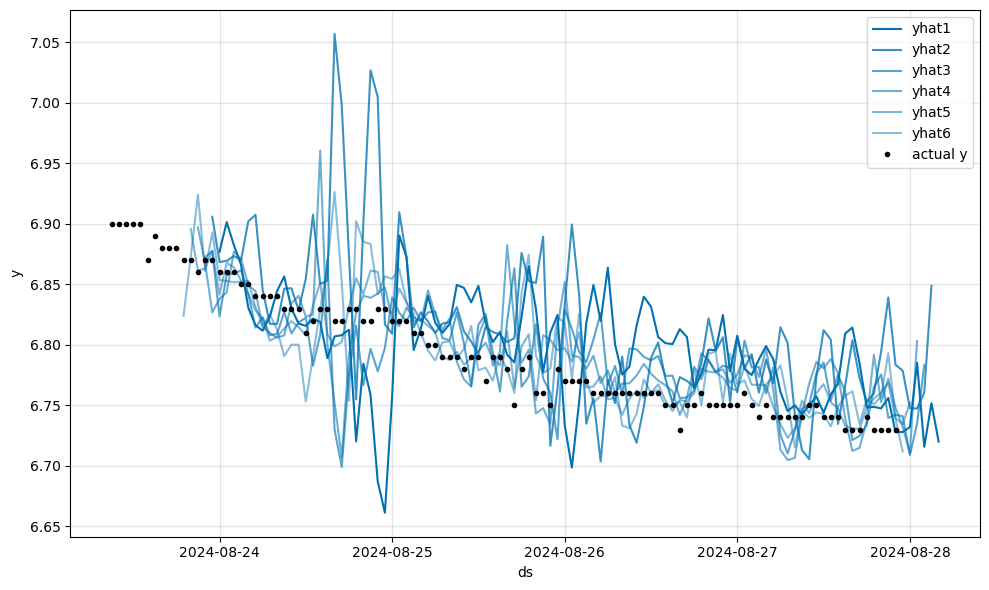

In [60]:
df_future = m.make_future_dataframe(df_test, n_historic_predictions=100, periods=n_forecasts) #df, periods=30, n_historic_predictions=100)

forecast = m.predict(df_future)
fig = m.plot(forecast)

In [61]:
forecast

,ds,y,residual1,yhat1,residual2,yhat2,residual3,yhat3,residual4,yhat4,...,lagged_regressor_Gage_diff6,lagged_regressor_Flow_diff1,lagged_regressor_Flow_diff2,lagged_regressor_Flow_diff3,lagged_regressor_Flow_diff4,lagged_regressor_Flow_diff5,lagged_regressor_Flow_diff6,trend,season_weekly,season_daily
0,2024-08-23 09:00:00,6.9,NaN,None,NaN,None,NaN,None,NaN,None,...,None,None,None,None,None,None,None,None,None,None
1,2024-08-23 10:00:00,6.9,NaN,None,NaN,None,NaN,None,NaN,None,...,None,None,None,None,None,None,None,None,None,None
2,2024-08-23 11:00:00,6.9,NaN,None,NaN,None,NaN,None,NaN,None,...,None,None,None,None,None,None,None,None,None,None
3,2024-08-23 12:00:00,6.9,NaN,None,NaN,None,NaN,None,NaN,None,...,None,None,None,None,None,None,None,None,None,None
4,2024-08-23 13:00:00,6.9,NaN,None,NaN,None,NaN,None,NaN,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2024-08-28 00:00:00,NaN,NaN,None,NaN,6.752075,NaN,6.710278,NaN,6.708878,...,1.485536,None,1.563446,1.179471,0.166366,2.94102,-0.562482,5.648628,0.006288,0.009915
112,2024-08-28 01:00:00,NaN,NaN,None,NaN,None,NaN,6.803268,NaN,6.734746,...,1.640372,None,None,1.191781,0.281308,2.879606,-0.658726,5.648628,0.005004,0.012768
113,2024-08-28 02:00:00,NaN,NaN,None,NaN,None,NaN,None,NaN,6.783502,...,1.50076,None,None,None,0.130251,2.966753,-0.549405,5.648628,0.003641,0.009543
114,2024-08-28 03:00:00,NaN,NaN,None,NaN,None,NaN,None,NaN,None,...,1.565855,None,None,None,None,2.911175,-0.612221,5.648628,0.00221,0.005022


In [62]:
forecast['yhat6'].tail(n_forecasts)

110    6.727954
111    6.732028
112    6.785175
113    6.715766
114     6.75184
115    6.719988
Name: yhat6, dtype: object

In [63]:
print('The 6 hour streamgage height for tge Schuylkill River at Conshohocken, PA is:', forecast['yhat6'].tail(1) )

The 6 hour streamgage height for tge Schuylkill River at Conshohocken, PA is: 115    6.719988
Name: yhat6, dtype: object


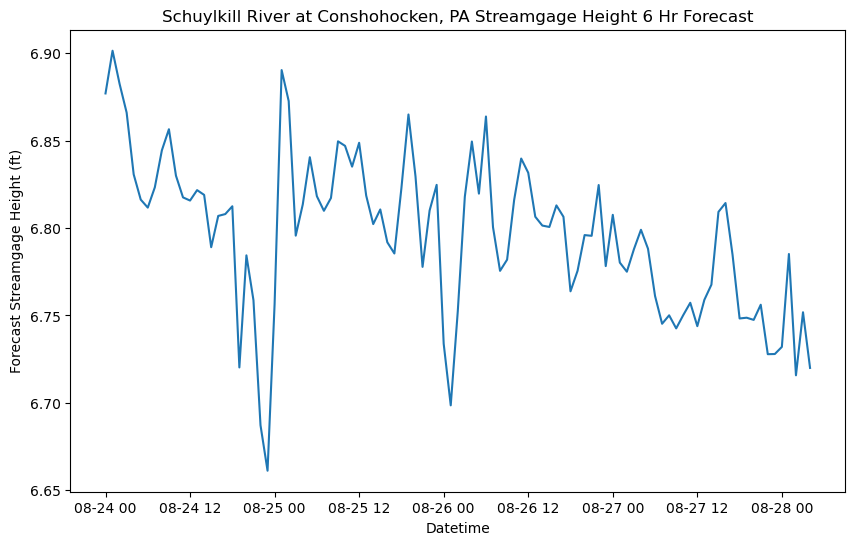

In [64]:
plt.figure(figsize=(10,6))
plt.plot(forecast['ds'],forecast['yhat6'])
plt.xlabel('Datetime')
plt.ylabel('Forecast Streamgage Height (ft)')
 
# displaying the title
plt.title("Schuylkill River at Conshohocken, PA Streamgage Height 6 Hr Forecast")
plt.show()